##                                                    Logan Mann
##                                                 Research Project 2

The goal of this project is to make a predictive model that can accurately predict Cetane values, particularly after reducing the number of features using Prinicpal Component Analysis

Import Required Packages

In [2]:
import numpy as np
import inspect
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import svm, metrics, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from os import mkdir
from os.path import isdir, join
from ecnet import Server
from ecnet.models.mlp import MultilayerPerceptron
from ecnet.utils.logging import logger

We create a server object from ECNet to get our random splits for training, validation and testing sets

In [3]:
sv = Server()
sv.load_data('cn_database_v2.0.csv', 
            random=True,
            split=[0.7, 0.2, 0.1])

Split our data into separate sets for training, validation and testing

In [4]:
train_set = []
valid_set = []
test_set = []
for data in sv._df.learn_set:
    train_set.append(data.id)
for data in sv._df.valid_set:
    valid_set.append(data.id)
for data in sv._df.test_set:
    test_set.append(data.id)
    
#Preview our data sets    
print(len(train_set))
print(len(valid_set))
print(len(test_set))

322
92
47


Import our data separately

In [5]:
data = pd.read_csv('cn_database_v2.0.csv')
#Lets turn the dataset into a dataframe
data.head(5)

C:\Users\logan\anaconda3\envs\ecnet\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,25

,DATAID,ASSIGNMENT,STRING,STRING.1,STRING.2,STRING.3,STRING.4,STRING.5,STRING.6,STRING.7,...,INPUT.5295,INPUT.5296,INPUT.5297,INPUT.5298,INPUT.5299,INPUT.5300,INPUT.5301,INPUT.5302,INPUT.5303,INPUT.5304
0,DATAID,ASSIGNMENT,Compound Name,SMILES,Compound Group,CG2,Formula,Source,Method,Validated By,...,CATS3D_10_LL,CATS3D_11_LL,CATS3D_12_LL,CATS3D_13_LL,CATS3D_14_LL,CATS3D_15_LL,CATS3D_16_LL,CATS3D_17_LL,CATS3D_18_LL,CATS3D_19_LL
1,UMLCN0001,L,"5,5'-(furan-2-ylmethylene)bis(2-methylfuran)",CC1=CC=C(O1)C(C2=CC=CO2)C3=CC=C(O3)C,Cyclic Ethers,Aromatics,C15H14O3,Kessler (2017),IQT,UML,...,0,0,0,0,0,0,0,0,0,0
2,UMLCN0002,V,2-butylfuran,CCCCC1=CC=CO1,Cyclic Ethers,Aromatics,C8H12O,Marquardt (2015),IQT,PubChem,...,0,0,0,0,0,0,0,0,0,0
3,UMLCN0003,L,tetrahydropyran,C1CCOCC1,Cyclic Ethers,NaN,C5H10O,Marquardt (2015),IQT,PubChem,...,0,0,0,0,0,0,0,0,0,0
4,UMLCN0004,L,"2,5-dimethylfuran",CC1=CC=C(C)O1,Cyclic Ethers,Aromatics,C6H8O,Marquardt (2015),IQT,PubChem,...,0,0,0,0,0,0,0,0,0,0


In [6]:
header = data.iloc[0, 300].reset_index(drop=True)
header

AttributeError: 'str' object has no attribute 'reset_index'

Lets create separate dataframes for each of our sets

In [7]:
datadf = data.iloc[:, ].reset_index(drop=True)

traindf = pd.DataFrame()
testdf = pd.DataFrame()
validdf = pd.DataFrame()

for molecule in train_set:
    tempdf = datadf.loc[datadf['DATAID'] == molecule, :].reset_index(drop=True)
    traindf = pd.concat([traindf,tempdf])

for molecule in test_set:
    tempdf = datadf.loc[datadf['DATAID'] == molecule, :].reset_index(drop=True)
    testdf = pd.concat([testdf,tempdf])
    
for molecule in valid_set:
    tempdf = datadf.loc[datadf['DATAID'] == molecule, :].reset_index(drop=True)
    validdf = pd.concat([validdf,tempdf])

In [8]:
X_train = traindf.iloc[:, 12:].reset_index(drop=True)
y_train = traindf.iloc[:, :12].reset_index(drop=True)

X_valid = validdf.iloc[:, 12:].reset_index(drop=True)
y_valid = validdf.iloc[:, :12].reset_index(drop=True)

X_test = testdf.iloc[:, 12:].reset_index(drop=True)
y_test = testdf.iloc[:, :12].reset_index(drop=True)

In [9]:
trainx = X_train.iloc[:, :].reset_index(drop=True)
testx = X_test.iloc[:, :].reset_index(drop=True)
validx = X_valid.iloc[:, :].reset_index(drop=True)
validy = y_valid.iloc[:, 11].reset_index(drop=True)
trainy = y_train.iloc[:, 11].reset_index(drop=True)
testy = y_test.iloc[:, 11].reset_index(drop=True)

In [11]:
y_train

,DATAID,ASSIGNMENT,STRING,STRING.1,STRING.2,STRING.3,STRING.4,STRING.5,STRING.6,STRING.7,STRING.8,TARGET
0,UMLCN0218,L,methylcyclohexane,CC1CCCCC1,Naphthenes,NaN,C7H14,Marquardt (2015),IQT,PubChem,NaN,24.4
1,UMLCN0479,L,pentyl acetate,CCCCCOC(=O)C,Esters,NaN,C7H14O2,NREL (2014),IQT,PubChem,NaN,23.6
2,UMLCN0446,L,4-propylphenol,CCCC1=CC=C(C=C1)O,Aromatics,Phenols,C9H12O,NREL (2014),IQT,PubChem,NaN,8.6
3,UMLCN0333,T,naphthalene,C1=CC=C2C=CC=CC2=C1,Aromatics,NaN,C10H8O,NREL (2014),"5%â€“7% Blend, CFR",PubChem,NaN,22
4,UMLCN0362,L,decyl valerate,CCCCCCCCCCOC(=O)CCCC,Esters,NaN,C15H30O2,BioCompoundML (2016),Unknown,PubChem,NaN,61
...,...,...,...,...,...,...,...,...,...,...,...,...
317,UMLCN0010,V,furfuryl alcohol,C1=COC(=C1)CO,Cyclic Ethers,Aromatics,C5H6O2,NREL (2014),IQT,PubChem,NaN,10.3
318,UMLCN0244,L,diethylene glycol monomethyl ether,OCCOCCOC,Olefins,NaN,C5H12O3,Marquardt (2015),IQT,PubChem,NaN,38.3
319,UMLCN0066,L,dibenzylether,C1=CC=C(C=C1)COCC2=CC=CC=C2,Aromatics,Ethers,C14H14O,Marquardt (2015),IQT,PubChem,NaN,8.1
320,UMLCN0035,L,oleyl alcohol,CCCCCCCCC=CCCCCCCCCO,Alcohols,Olefins,C18H36O,NREL (2014),Other Ignition Delay Method,PubChem,NaN,51.0


In [10]:
train = pd.concat([trainy, trainx], axis=1, join='inner').reset_index(drop=True)
test = pd.concat([testy, testx], axis=1, join='inner').reset_index(drop=True)
valid = pd.concat([validy, validx], axis=1, join='inner').reset_index(drop=True)

In [13]:
train

,TARGET,INPUT,INPUT.1,INPUT.2,INPUT.3,INPUT.4,INPUT.5,INPUT.6,INPUT.7,INPUT.8,...,INPUT.5295,INPUT.5296,INPUT.5297,INPUT.5298,INPUT.5299,INPUT.5300,INPUT.5301,INPUT.5302,INPUT.5303,INPUT.5304
0,24.4,98.21,4.67667,10.6876,20.1852,12.3298,23.9064,0.508933,0.9612,0.587133,...,0,0,0,0,0,0,0,0,0,0
1,23.6,130.21,5.6613,12.1172,22.8398,13.2388,26.3252,0.526835,0.993035,0.5756,...,0,0,0,0,0,0,0,0,0,0
2,8.6,136.21,6.19136,12.8756,21.6289,14.0229,24.7006,0.585255,0.983132,0.637405,...,0,0,0,0,0,0,0,0,0,0
3,22,128.18,7.12111,12.1072,17.5344,13.0456,19.6608,0.672622,0.974133,0.724756,...,0,0,0,0,0,0,0,0,0,0
4,61,242.45,5.15851,24.3316,45.9086,27.33,53.6468,0.517694,0.976779,0.581489,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,10.3,98.11,7.546923077,8.01,13.3054,8.1932,14.6644,0.616153846,1.023492308,0.630246154,...,0,0,0,0,0,0,0,0,0,0
318,38.3,120.17,6.0085,10.3052,20.2835,10.9319,23.1194,0.51526,1.01418,0.546595,...,0,0,0,0,0,0,0,0,0,0
319,8.1,198.28,6.837241379,18.4024,28.5125,19.7843,32.1158,0.634565517,0.983189655,0.682217241,...,0,0,0,0,0,0,0,0,0,0
320,51.0,268.54,4.882545455,28.1972,53.2321,32.1597,62.683,0.512676364,0.967856364,0.584721818,...,0,0,0,0,0,0,0,0,0,0


In [11]:
full_data = pd.concat((train, valid, test)).reset_index(drop=True).astype(float)

In [12]:
y_train

,DATAID,ASSIGNMENT,STRING,STRING.1,STRING.2,STRING.3,STRING.4,STRING.5,STRING.6,STRING.7,STRING.8,TARGET
0,UMLCN0452,L,indan,C1CC2=CC=CC=C2C1,Aromatics,Cyclic,C9H10,NREL (2014),IQT,PubChem,NaN,8.6
1,UMLCN0264,L,2-methylheptadecane,CCCCCCCCCCCCCCCC(C)C,Alkanes,NaN,C18H38,Marquardt (2015),IQT,PubChem,NaN,91.0
2,UMLCN0151,L,"2,2-dimethoxypropane",CC(OC)(OC)C,Ethers,NaN,C5H12O2,Marquardt (2015),IQT,PubChem,NaN,31.3
3,UMLCN0386,L,ethyl laurate,CCCCCCCCCCCC(=O)OCC,Esters,NaN,C14H28O2,BioCompoundML (2016),Unknown,PubChem,NaN,73.0
4,UMLCN0357,V,decyl caprate,CCCCCCCCCCOC(=O)CCCCCCCCC,Esters,NaN,C20H40O2,BioCompoundML (2016),Unknown,UML,decyl decanoate,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...
317,UMLCN0430,T,"3,3-Diethylpentane",CCC(CC)(CC)CC,Alkanes,NaN,C9H20,Kubic (2016),Unknown,PubChem,NaN,17.0
318,UMLCN0029,L,"3,7-dimethyl-1-octanol",CC(C)CCCC(C)CCO,Alcohols,NaN,C10H22O,Marquardt (2015),IQT,PubChem,NaN,29.3
319,UMLCN0054,V,dodecan-1-ol,CCCCCCCCCCCCO,Alcohols,NaN,C12H26O,NREL (2014),CFR,PubChem,NaN,63.6
320,UMLCN0317,T,1-tetradecene,CCCCCCCCCCCCC=C,Olefins,NaN,C14H28,NREL (2014),Unknown,PubChem,NaN,80.9


Cetane is the variable we need to predict, so lets do some analysis on that variable first


 mean = 39.53 and st. dev = 25.57



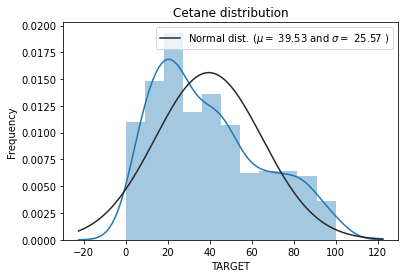

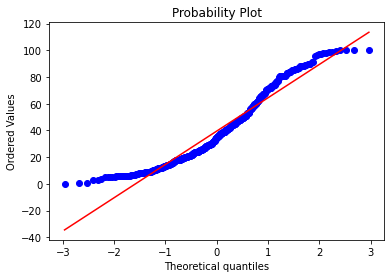

In [66]:
sns.distplot(full_data['TARGET'] , fit=norm)
(mu, sigma) = norm.fit(full_data['TARGET'])
print( '\n mean = {:.2f} and st. dev = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Cetane distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(full_data['TARGET'], plot=plt)
plt.show()

As we can see from the histogram, our data is NOT normally distributed. Our data seems to be slightly skewed left. It could be good to transform our target variable to have a more normal distribution for more accurate predictions. For now though, we will comment out the transformation


 mean = 39.53 and st. dev = 25.57



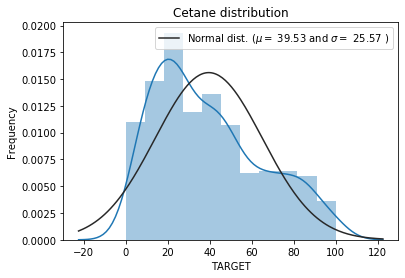

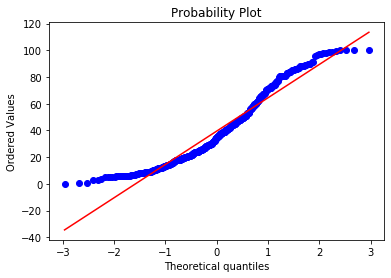

In [12]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#full_data['TARGET'] = np.log1p(full_data['TARGET'])

#Check the new distribution 
sns.distplot(full_data['TARGET'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(full_data['TARGET'])
print( '\n mean = {:.2f} and st. dev = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Cetane distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(full_data['TARGET'], plot=plt)
plt.show()

Now lets try to focus on some feature engineering

In [13]:
#Here we concat all of our data into one dataframe for some easier preprocessing
ntrain = train.shape[0]
nvalid = valid.shape[0]
ntest = test.shape[0]
y_train_new = train.TARGET.values
y_test_new = test.TARGET.values
y_valid_new = valid.TARGET.values
targets = full_data['TARGET']
#all_data = pd.concat((train, valid, test)).reset_index(drop=True)
full_data.drop(['TARGET'], axis=1, inplace=True)
#all_data.head()

After having all of our data into one dataframe, we check if there is any missing data.

In [14]:
data_na = (full_data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head()

,Missing Ratio


Here we can see there is no missing data, now lets check the skew of our input data

Normality is often assumed with statistical techniques; if you’re using regression algorithms such as linear regression or neural networks, you are likely to see large improvements if you transform variables with skewed distributions. So lets try to transform our input data

In [15]:
numeric_feats = full_data.dtypes[full_data.dtypes != 'object'].index
# Check the skew of all numerical features
skewed_feats = full_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)


Skew in numerical features: 



,Skew
INPUT.1251,21.400985
INPUT.78,21.400985
INPUT.58,21.400985
INPUT.170,21.400985
INPUT.70,21.400985


We preview our data before our transformation

In [16]:
full_data.head()

,INPUT,INPUT.1,INPUT.2,INPUT.3,INPUT.4,INPUT.5,INPUT.6,INPUT.7,INPUT.8,INPUT.9,...,INPUT.5295,INPUT.5296,INPUT.5297,INPUT.5298,INPUT.5299,INPUT.5300,INPUT.5301,INPUT.5302,INPUT.5303,INPUT.5304
0,326.63,5.025077,33.4924,63.2102,37.8984,74.1380,0.515268,0.972465,0.583052,1.140585,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,140.30,4.676667,15.2680,28.8360,17.6140,34.1520,0.508933,0.961200,0.587133,1.138400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,138.18,6.909000,12.0636,20.0726,12.7160,22.4948,0.603180,1.003630,0.635800,1.124740,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100.23,4.357826,11.2144,22.0688,13.0912,26.3216,0.487583,0.959513,0.569183,1.144417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,128.24,5.129600,12.9292,24.3961,14.5457,28.5310,0.517168,0.975844,0.581828,1.141240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now perform a boxcox transformation on all the data that is slightly skewed

In [17]:
#Here we perform a boxcox transformation on all the data that is skewed.
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    full_data[feat] = boxcox1p(full_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 5305 skewed numerical features to Box Cox transform


We preview it after our transformation

In [18]:
full_data.head()

,INPUT,INPUT.1,INPUT.2,INPUT.3,INPUT.4,INPUT.5,INPUT.6,INPUT.7,INPUT.8,INPUT.9,...,INPUT.5295,INPUT.5296,INPUT.5297,INPUT.5298,INPUT.5299,INPUT.5300,INPUT.5301,INPUT.5302,INPUT.5303,INPUT.5304
0,9.226714,2.061100,4.672137,5.779894,4.878455,6.076803,0.428819,0.715097,0.475550,0.806224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.343073,1.983466,3.463320,4.428142,3.670100,4.704401,0.424362,0.708758,0.478309,0.805079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.311341,2.424654,3.135412,3.864257,3.207327,4.037540,0.489099,0.732475,0.510752,0.797900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.659496,1.908786,3.037082,4.008201,3.247380,4.282591,0.409221,0.707806,0.466129,0.808229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.156842,2.083646,3.230199,4.163217,3.394545,4.411055,0.430153,0.716992,0.474721,0.806567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, our box cox transformation caused some input features to be NaN values, so we must impute some missing data

In [19]:
#Wherever there is a NaN, lets replace it with the mean of the column it is in.
impute1 = full_data.fillna(full_data.mean())
impute1.head()

,INPUT,INPUT.1,INPUT.2,INPUT.3,INPUT.4,INPUT.5,INPUT.6,INPUT.7,INPUT.8,INPUT.9,...,INPUT.5295,INPUT.5296,INPUT.5297,INPUT.5298,INPUT.5299,INPUT.5300,INPUT.5301,INPUT.5302,INPUT.5303,INPUT.5304
0,9.226714,2.061100,4.672137,5.779894,4.878455,6.076803,0.428819,0.715097,0.475550,0.806224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.343073,1.983466,3.463320,4.428142,3.670100,4.704401,0.424362,0.708758,0.478309,0.805079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.311341,2.424654,3.135412,3.864257,3.207327,4.037540,0.489099,0.732475,0.510752,0.797900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.659496,1.908786,3.037082,4.008201,3.247380,4.282591,0.409221,0.707806,0.466129,0.808229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.156842,2.083646,3.230199,4.163217,3.394545,4.411055,0.430153,0.716992,0.474721,0.806567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see, there are some columns that are filled entirely of NaN values. So we will just drop those columns

In [20]:
null_columns=impute1.columns[impute1.isnull().any()]
print(impute1[impute1.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [21]:
filled_data = impute1.dropna(axis = 1, how = 'all')

In [22]:
numeric_feats = filled_data.dtypes[filled_data.dtypes != 'object'].index
# Check the skew of all numerical features
skewed_feats = filled_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()


Skew in numerical features: 



,Skew
INPUT.2976,21.400985
INPUT.2869,21.400985
INPUT.58,21.400985
INPUT.4998,21.400985
INPUT.66,21.400985


As we can see there are still some columns who's data is skewed significantly. If we look into these features we might be able to find out the reasons as to why this is happening

In [77]:
filled_data['INPUT.1324']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
456    0.0
457    0.0
458    0.0
459    0.0
460    0.0
Name: INPUT.1324, Length: 461, dtype: float64

In [26]:
filled_data['INPUT.1333']

0      1.960441
1      2.091038
2      1.996073
3      2.017143
4      2.059373
         ...   
456    2.002378
457    2.120464
458    1.996073
459    1.946444
460    1.972408
Name: INPUT.1333, Length: 461, dtype: float64

It seems as if the data that is skewed heavily is due to the features being filled of mostly zeros. I do not know the best course of action to take with this data so we will keep it for now. 

Note: 

This might not be the best course of action to take for accuracy

Splitting our training and testing sets again

In [23]:
train = filled_data[:ntrain]
valid = filled_data[ntrain:(ntrain+nvalid)]
test = filled_data[(ntrain+nvalid):]

#train = full_data[:ntrain]
#valid = full_data[ntrain:(ntrain+nvalid)]
#test = full_data[(ntrain+nvalid):]


train.head()

,INPUT,INPUT.1,INPUT.2,INPUT.3,INPUT.4,INPUT.5,INPUT.6,INPUT.7,INPUT.8,INPUT.9,...,INPUT.5295,INPUT.5296,INPUT.5297,INPUT.5298,INPUT.5299,INPUT.5300,INPUT.5301,INPUT.5302,INPUT.5303,INPUT.5304
0,9.226714,2.061100,4.672137,5.779894,4.878455,6.076803,0.428819,0.715097,0.475550,0.806224,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.343073,1.983466,3.463320,4.428142,3.670100,4.704401,0.424362,0.708758,0.478309,0.805079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.311341,2.424654,3.135412,3.864257,3.207327,4.037540,0.489099,0.732475,0.510752,0.797900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.659496,1.908786,3.037082,4.008201,3.247380,4.282591,0.409221,0.707806,0.466129,0.808229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.156842,2.083646,3.230199,4.163217,3.394545,4.411055,0.430153,0.716992,0.474721,0.806567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
###############################################################################
# Compute a PCA: unsupervised feature extraction / dimensionality reduction

#n-components, how many features we want our data to keep
n_components = 300

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(train)

We will now transform our data. As a result we will have a new dataframe with however many columns we specified before. 
NOTE: These will NOT be original columns from our original dataframe
Rather, they will be a transformation of our data into a new dataframe with less features

The explained variance tells you how much information (variance) can be attributed to each of the principal components.
This is important as while you can convert 4 dimensional space to 2 dimensional space, you lose some of the variance (information) when you do this.

In [25]:
X_train_pca = pca.transform(train)
X_test_pca = pca.transform(test)
X_valid_pca = pca.transform(valid)

total = 0
for x in pca.explained_variance_ratio_:
    total = total + x
print(total)

0.999998766832704


In [26]:
X_train_pca

array([[ 1.52783279, -0.68834304, -0.36847063, ...,  0.1925621 ,
         0.66928662, -0.43196279],
       [-0.38040755,  0.36635089, -1.48019323, ...,  0.81962745,
        -0.03463042,  0.1491636 ],
       [-0.56250133, -0.50461329,  2.28751309, ..., -0.15613547,
         0.13455055, -0.2506972 ],
       ...,
       [ 0.65139356,  1.50379445,  0.5456928 , ...,  0.02215091,
        -0.45345743, -0.0593539 ],
       [ 0.7024792 , -0.33970113,  0.95548734, ..., -0.07330005,
         0.0284189 , -0.12277082],
       [-1.05634101,  0.49551389, -0.88916926, ..., -1.02419839,
         0.16333435, -0.46147554]])

Here we see many things:

300 components contain roughly 99.99999% of our information

250 components contain roughly 99.998% of our information

200 components contain roughly 99.99% of our information

175 components contain roughly 99.98% of our information

150 components contain roughly 99.96% of our information

125 components contain roughly 99.9% of our information

100 components contain roughly 99.8% of our information

75 components contain roughly 99.75% of our information

50 components contain roughly 99.5% of our information

45 components contain roughly 99.3% of our information

30 components contain roughly 99% of our information

25 components contain roughly 98% of our information

20 components contain roughly 98% of our information

15 components contain roughly 97.5% of our information

10 components contain roughly 96% of our information

In [27]:
#We choose 300 features
#learning, validation, testing
#L, V, T

ytraindf = pd.DataFrame(data = y_train).reset_index(drop=True)

traindf = pd.DataFrame(data = X_train_pca)
traindf = pd.concat([ytraindf, traindf], axis = 1)
traindf['ASSIGNMENT'] = 'L'

#targetdf = pd.DataFrame(data = targets,
#                       columns = ['TARGET']).reset_index(drop=True)

ytestdf = pd.DataFrame(data = y_test).reset_index(drop=True)

testdf = pd.DataFrame(data = X_test_pca)
testdf = pd.concat([ytestdf, testdf], axis = 1)
testdf['ASSIGNMENT'] = 'T'

yvaliddf = pd.DataFrame(data = y_valid).reset_index(drop=True)

validdf = pd.DataFrame(data = X_valid_pca)
validdf = pd.concat([yvaliddf, validdf], axis = 1)
validdf['ASSIGNMENT'] = 'V'

finaldf = traindf.append([validdf, testdf])
#finaldf['TARGET'] = targetdf
finaldf.sort_values(by=['DATAID'], inplace=True)
finaldf

,DATAID,ASSIGNMENT,STRING,STRING.1,STRING.2,STRING.3,STRING.4,STRING.5,STRING.6,STRING.7,...,290,291,292,293,294,295,296,297,298,299
294,UMLCN0001,L,"5,5'-(furan-2-ylmethylene)bis(2-methylfuran)",CC1=CC=C(O1)C(C2=CC=CO2)C3=CC=C(O3)C,Cyclic Ethers,Aromatics,C15H14O3,Kessler (2017),IQT,UML,...,-0.159418,0.061750,0.029815,0.078600,0.097531,0.104831,0.031430,0.126198,-0.035882,0.020989
5,UMLCN0002,V,2-butylfuran,CCCCC1=CC=CO1,Cyclic Ethers,Aromatics,C8H12O,Marquardt (2015),IQT,PubChem,...,-3.181851,-1.412063,16.743419,-1.076257,0.137629,-0.420178,4.244455,-5.318677,6.036167,-6.867524
80,UMLCN0003,L,tetrahydropyran,C1CCOCC1,Cyclic Ethers,NaN,C5H10O,Marquardt (2015),IQT,PubChem,...,-0.134621,-0.200912,-0.239496,-0.125695,-0.178538,0.156224,-0.261589,0.280013,0.267055,-0.063643
23,UMLCN0004,V,"2,5-dimethylfuran",CC1=CC=C(C)O1,Cyclic Ethers,Aromatics,C6H8O,Marquardt (2015),IQT,PubChem,...,11.891817,-6.903126,5.524788,-1.781570,12.559372,-14.451979,-10.614946,4.661064,12.704172,1.578773
48,UMLCN0005,L,"2,5-dihydrofuran",C1C=CCO1,Cyclic Ethers,Olefins,C4H6O,Marquardt (2015),IQT,PubChem,...,0.262269,0.448118,0.264122,0.440953,0.014878,-0.126972,0.296630,0.040506,-0.177258,-0.164314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,UMLCN0478,L,hexyl hexanoate,CCCCCCOC(=O)CCCCC,Esters,NaN,C12H24O2,NREL (2014),IQT,PubChem,...,1.359773,-0.946507,-0.305087,1.477259,-0.353881,0.267160,0.461641,0.083114,0.439986,0.885876
183,UMLCN0479,L,pentyl acetate,CCCCCOC(=O)C,Esters,NaN,C7H14O2,NREL (2014),IQT,PubChem,...,0.258496,-0.042546,0.342671,0.483493,0.594913,-0.197278,1.078366,-0.259144,0.297326,0.238594
250,UMLCN0480,L,furfuryl ethyl ether,CCOCC1=CC=CO1,Cyclic Ethers,Aromatics,C7H10O2,NREL (2014),IQT,PubChem,...,0.014926,0.140777,-0.306975,-0.166812,-0.007932,-0.001924,-0.217051,0.144670,0.240944,-0.010645
128,UMLCN0481,L,ethyl tetrahydrofurfuryl ether,CCOCC1CCCO1,Cyclic Ethers,Ethers,C7H14O2,NREL (2014),IQT,PubChem,...,0.414074,-0.520121,0.363515,-0.075549,0.208709,0.330749,0.262019,0.452672,-0.122931,0.230555


In [29]:
finaldf

,DATAID,ASSIGNMENT,STRING,STRING.1,STRING.2,STRING.3,STRING.4,STRING.5,STRING.6,STRING.7,...,290,291,292,293,294,295,296,297,298,299
294,UMLCN0001,L,"5,5'-(furan-2-ylmethylene)bis(2-methylfuran)",CC1=CC=C(O1)C(C2=CC=CO2)C3=CC=C(O3)C,Cyclic Ethers,Aromatics,C15H14O3,Kessler (2017),IQT,UML,...,-0.159418,0.061750,0.029815,0.078600,0.097531,0.104831,0.031430,0.126198,-0.035882,0.020989
5,UMLCN0002,V,2-butylfuran,CCCCC1=CC=CO1,Cyclic Ethers,Aromatics,C8H12O,Marquardt (2015),IQT,PubChem,...,-3.181851,-1.412063,16.743419,-1.076257,0.137629,-0.420178,4.244455,-5.318677,6.036167,-6.867524
80,UMLCN0003,L,tetrahydropyran,C1CCOCC1,Cyclic Ethers,NaN,C5H10O,Marquardt (2015),IQT,PubChem,...,-0.134621,-0.200912,-0.239496,-0.125695,-0.178538,0.156224,-0.261589,0.280013,0.267055,-0.063643
23,UMLCN0004,V,"2,5-dimethylfuran",CC1=CC=C(C)O1,Cyclic Ethers,Aromatics,C6H8O,Marquardt (2015),IQT,PubChem,...,11.891817,-6.903126,5.524788,-1.781570,12.559372,-14.451979,-10.614946,4.661064,12.704172,1.578773
48,UMLCN0005,L,"2,5-dihydrofuran",C1C=CCO1,Cyclic Ethers,Olefins,C4H6O,Marquardt (2015),IQT,PubChem,...,0.262269,0.448118,0.264122,0.440953,0.014878,-0.126972,0.296630,0.040506,-0.177258,-0.164314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,UMLCN0478,L,hexyl hexanoate,CCCCCCOC(=O)CCCCC,Esters,NaN,C12H24O2,NREL (2014),IQT,PubChem,...,1.359773,-0.946507,-0.305087,1.477259,-0.353881,0.267160,0.461641,0.083114,0.439986,0.885876
183,UMLCN0479,L,pentyl acetate,CCCCCOC(=O)C,Esters,NaN,C7H14O2,NREL (2014),IQT,PubChem,...,0.258496,-0.042546,0.342671,0.483493,0.594913,-0.197278,1.078366,-0.259144,0.297326,0.238594
250,UMLCN0480,L,furfuryl ethyl ether,CCOCC1=CC=CO1,Cyclic Ethers,Aromatics,C7H10O2,NREL (2014),IQT,PubChem,...,0.014926,0.140777,-0.306975,-0.166812,-0.007932,-0.001924,-0.217051,0.144670,0.240944,-0.010645
128,UMLCN0481,L,ethyl tetrahydrofurfuryl ether,CCOCC1CCCO1,Cyclic Ethers,Ethers,C7H14O2,NREL (2014),IQT,PubChem,...,0.414074,-0.520121,0.363515,-0.075549,0.208709,0.330749,0.262019,0.452672,-0.122931,0.230555


In [82]:
#We now need to get our final df to have train/test splits that are np arrays
X_traindf = finaldf.loc[finaldf['ASSIGNMENT'] == 'L', :].reset_index(drop=True)
X_train = X_traindf.iloc[:, 12:].to_numpy()
y_train = X_traindf.iloc[:, 11].to_numpy()

X_validdf = finaldf.loc[finaldf['ASSIGNMENT'] == 'V', :].reset_index(drop=True)
X_valid = X_validdf.iloc[:, 12:].to_numpy()
y_valid = X_validdf.iloc[:, 11].to_numpy()

X_testdf = finaldf.loc[finaldf['ASSIGNMENT'] == 'T', :].reset_index(drop=True)
X_test = X_testdf.iloc[:, 12:].to_numpy()
y_test = X_testdf.iloc[:, 11].to_numpy()

In [28]:
finaldf.to_csv(r'300pcav2.0.csv', index = False, header=True)

We create an MLP with the input layer, then hidden layers with 150, and 75 neurons.

In [31]:
from ecnet.models.mlp import MultilayerPerceptron as mp
model = mp(filename = 'model1.h5')
model.add_layer(num_neurons = 150, activation = 'relu', input_dim = 300)
model.add_layer(num_neurons = 75, activation = 'relu')
model.add_layer(num_neurons = 1, activation = 'linear')

#We fit the model

model.fit(X_train, y_train, X_valid, y_valid, 3000, 0.001, 0.9, 0.999, 0.0000001, 0.0, 0, 32)

Get our median absolute error

In [32]:
from sklearn.metrics import median_absolute_error
results = model.use(X_test)
median_absolute_error(y_true = y_test, y_pred = results)

24.928173065185547

In [33]:
y_test

array(['98.0', '53.0', '14.4', '34.2', '41.0', '48.0', '17.0', '25.7',
       '20.0', '17.0', '30.0', '8.0', '22.0', '6.1', '23.0', '5.6',
       '52.0', '59.0', '28.1', '19.1', '81.0', '19.2', '84.0', '61.0',
       '29.0', '45.0', '11.0', '39.0', '22.3', '41.1', '6.0', '59.8',
       '1.0', '88.0', '42.2', '20.0', '18.0', '13.1', '25.0', '51.0',
       '99.0', '20.6', '76.8', '39.0', '51.0', '20.7', '34.2'],
      dtype=object)

In [35]:
results

array([[ 17.696682],
       [ 25.245314],
       [ 40.99291 ],
       [ 24.135149],
       [ 19.403765],
       [ 20.894665],
       [ 13.534136],
       [ 41.33566 ],
       [ 14.443165],
       [ 37.96658 ],
       [ 13.75378 ],
       [ 47.719128],
       [ 46.928173],
       [ 40.557545],
       [ 31.406296],
       [138.31511 ],
       [ 20.455256],
       [ 30.34193 ],
       [ 42.582455],
       [ 55.387585],
       [ 11.181298],
       [ 24.450928],
       [ 18.237316],
       [ 21.8236  ],
       [ 23.002197],
       [ 26.365139],
       [ 45.23143 ],
       [ 14.185222],
       [ 44.004566],
       [ 31.826843],
       [ 34.255524],
       [ 31.07067 ],
       [ 27.428223],
       [ 13.272573],
       [ 15.711561],
       [ 25.52585 ],
       [ 47.627792],
       [ 17.913305],
       [ 11.806302],
       [ 28.120546],
       [ 39.527443],
       [ 26.079437],
       [  9.458813],
       [ 18.130562],
       [ 22.555756],
       [ 19.615387],
       [ 32.34928 ]], dtype=float3